## Integrate MERFISH experiments after QC filtering

In [1]:
import scanpy as sc
import scvi
from tqdm.notebook import tqdm
import os
import numpy as np
import pandas as pd
from scvi.model.utils import mde
import matplotlib.pyplot as plt
import pickle
import glob

/home/amonell/mambaforge/envs/scvi-env_gpu/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/amonell/mambaforge/envs/scvi-env_gpu/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (


In [2]:
sc.set_figure_params(figsize=(4, 4))

Add the paths to all folders for experiments to be integrated

In [8]:
input_folders = glob.glob('/mnt/sata1/Analysis_Alex/human_r1/human_0*')

In [9]:
output_folder = r'/mnt/sata1/Analysis_Alex/human_r1/analysis/cleaned'

Run scvi integration

In [10]:
adata_list = []
for input_file in tqdm(input_folders):
    experiment = sc.read(os.path.join(input_file, 'adatas', '04_axes_in_preparation.h5ad'))
    experiment.obs['batch'] = os.path.basename(input_file)
    adata_list.append(experiment.copy())

concatenated = sc.concat(adata_list)

concatenated.obs_names_make_unique()
concatenated.layers['counts'] = concatenated.X
scvi.model.SCVI.setup_anndata(concatenated, layer="counts", batch_key="batch")
vae = scvi.model.SCVI(concatenated, n_layers=2, n_latent=30, gene_likelihood="nb")
vae.train()

  0%|          | 0/4 [00:00<?, ?it/s]

/home/amonell/mambaforge/envs/scvi-env_gpu/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/amonell/mambaforge/envs/scvi-env_gpu/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/amonell/mambaforge/envs/scvi-env_gpu/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/amonell/mambaforge/envs/scvi-env_gpu/lib/python3.9/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/amonell/mambaforge/envs/scvi-env_gpu/lib/python3.9/abc.py:119: Future

Epoch 37/37: 100%|██████████| 37/37 [04:31<00:00,  7.28s/it, v_num=1, train_loss_step=137, train_loss_epoch=134]

`Trainer.fit` stopped: `max_epochs=37` reached.


Epoch 37/37: 100%|██████████| 37/37 [04:31<00:00,  7.33s/it, v_num=1, train_loss_step=137, train_loss_epoch=134]


Use integration to calculate new clustering and neighbors

In [11]:
concatenated.obsm["X_scVI"] = vae.get_latent_representation()

In [12]:
sc.pp.neighbors(concatenated, use_rep="X_scVI")


Use MDE as new visualization

In [13]:
concatenated.obsm["X_mde"] = mde(concatenated.obsm["X_scVI"])

In [15]:
concatenated.obs['new_batch'] = concatenated.obs.batch.values

In [16]:
xcoords=concatenated.obsm["X_mde"][:, 0]
ycoords=concatenated.obsm["X_mde"][:, 1]
category_names = concatenated.obs.new_batch.values

In [18]:
sc.tl.leiden(concatenated)

In [20]:
concatenated.write(os.path.join(output_folder, 'concatenated_integrated.h5ad'))

/home/amonell/mambaforge/envs/scvi-env_gpu/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/amonell/mambaforge/envs/scvi-env_gpu/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


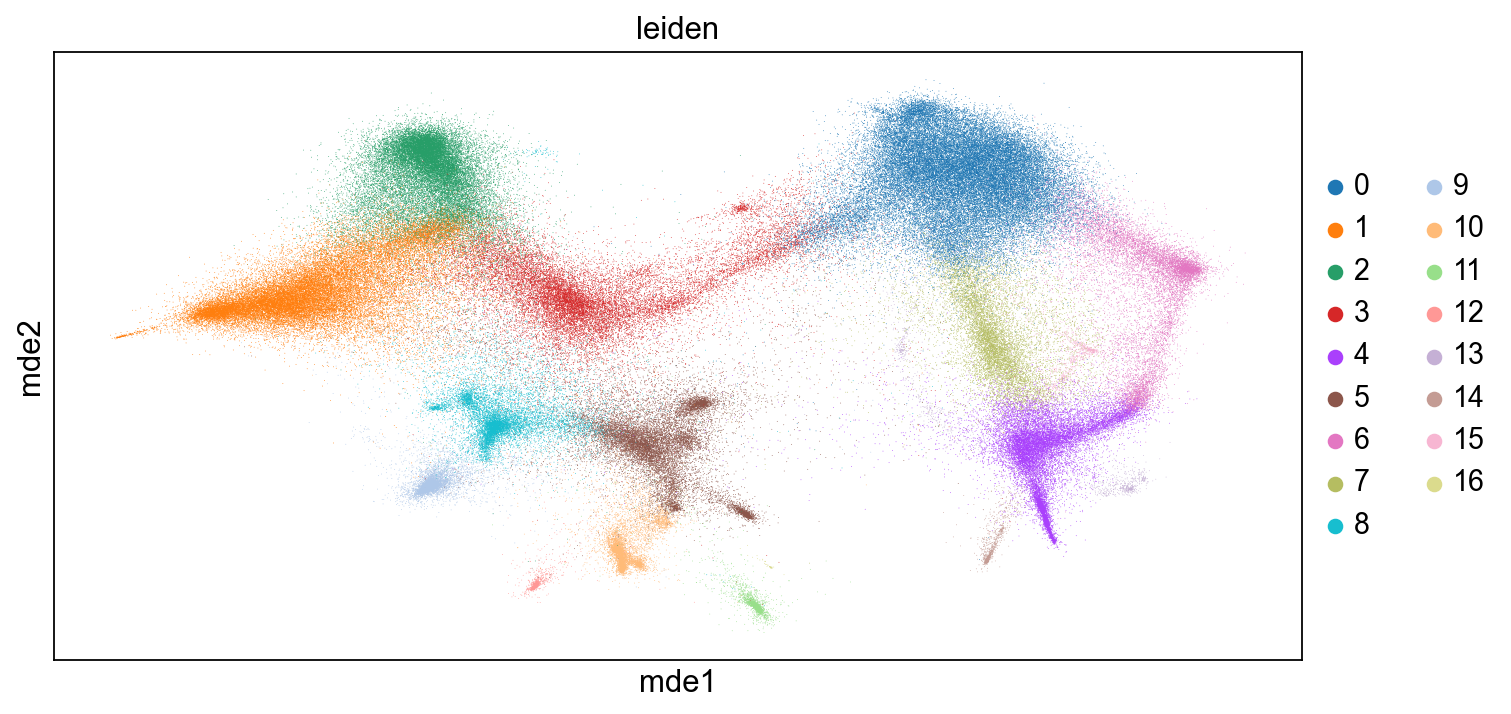

In [21]:
sc.set_figure_params(figsize=(10, 5))
sc.pl.embedding(concatenated, basis='mde', color=['leiden'])

## Save our SCVI VAE

In [22]:
import pickle

# File path where you want to save the object
file_path = os.path.join(output_folder, "vae_object.pkl")

# Dump the object to the file
with open(file_path, "wb") as file:
    pickle.dump(vae, file)
